In [ ]:
pip install benchmarkfcns==2.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
from benchmarkfcns import exponential

Function 1(exponential): $$f(\mathbf{x})=f(x_1, ..., x_n)=-exp(-0.5\sum_{i=1}^n{x_i^2})$$




Gradient Calculation:
$$f(\mathbf{x})=f(x_1, ..., x_n)=-exp(-0.5\sum_{i=1}^n{x_i^2})$$
$$\sum_{i=1}^n{x_i^2} = ||x||^2$$
$$f(\mathbf{x})= -exp(-.5 * ||x||^2)$$

$$\frac{\partial f}{\partial x_i} = -\exp\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) \cdot \frac{d}{dx_i}\left(-\frac{1}{2} \|\mathbf{x}\|^2\right)$$
$$\frac{d}{dx_i}\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) = -x_i$$
$$\nabla f(\mathbf{x}) = \exp\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) \cdot \mathbf{x}
$$

Hessian Calculation:

$$
H(\mathbf{x}) = \frac{\partial}{\partial \mathbf{x}} \left( \exp\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) \cdot \mathbf{x} \right)
$$

Using the product rule:
$$
H(\mathbf{x}) = \frac{\partial}{\partial \mathbf{x}} \left( \exp\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) \right) \cdot \mathbf{x}^T + \exp\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) \cdot I
$$



The derivative of the exponential term is:
$$
\frac{\partial}{\partial \mathbf{x}} \left( \exp\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) \right) = -\exp\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) \cdot \mathbf{x}
$$


$$
H(\mathbf{x}) = \exp\left(-\frac{1}{2} \|\mathbf{x}\|^2\right) \left( I - \mathbf{x}\mathbf{x}^T \right)$$


In [ ]:
# input dimension
n = 5

#function
def f(x):
    # print(x.shape)
    x2 = x ** 2

    scores = -torch.exp(-0.5 * torch.sum(x2))

    return scores

#gradient
def grad_f(x):
  # exponential part
  exp_part = torch.exp(-0.5 * torch.sum(x ** 2))
  # gradient calculation
  grad = exp_part * x

  return grad

#hessian
def hes(x):
    exp_part = torch.exp(-0.5 * torch.sum(x ** 2))  # scalar factor

    dim = x.shape[0]  # number of variables

    I = torch.eye(dim, dtype=x.dtype, device=x.device)  # identity matrix

    outer_product = torch.matmul(x, x.T)  # outer product: x x^T

    H = exp_part * (I - outer_product)  # hessian matrix

    return H

#gradient using automatic differentiation
def grad_f_AD(x):
  dim = x.shape[0]
  x.requires_grad = True
  y = f(x)
  dy = torch.autograd.grad(outputs = y, inputs = x, grad_outputs = torch.ones_like(y), create_graph = True)[0]
  x = x.detach()
  y = y.detach()
  dy = dy.detach()
  return dy

# hessian using automatic differentiation
def hes_f_AD(x):
  x.requires_grad = True
  y = f(x)
  dy = torch.autograd.grad(outputs = y, inputs = x, grad_outputs = torch.ones_like(y), create_graph = True)[0]

  #initialize hessian
  dim = x.shape[0]
  H = torch.zeros((dim, dim), dtype=x.dtype, device=x.device)

  #identity matrix
  I = torch.eye(dim, dtype=x.dtype, device = x.device)

  # for loop through identity matrix to compute second derivates
  for i in range(dim):
    grad_output = I[i].unsqueeze(-1) # make it dim,1 instead of dim
    second_grad = torch.autograd.grad(outputs=dy, inputs = x, grad_outputs=grad_output, create_graph=True)[0] # use identity instead of all ones to to compute second derivatives related to each variables
    H[i] = second_grad.squeeze()

  #detach variables
  H = H.detach()
  dy = dy.detach()
  x = x.detach()

  return H


In [ ]:
#test function
X = torch.rand(1000, n)

f1Out = exponential(X)
passed = True

for i in range(1000):
  f2 = f(X[i])
  # print(X[i].shape)
  if abs(f1Out[i] - f2) > .0005:
    passed = False
    print('error')
    print(f1Out[i])
    #print(X[i])
    print(f2)
    break
if passed:
  print('passed')


passed


In [ ]:
dim = n
x = torch.randn(dim,1)
v = torch.randn_like(x)
v = v / torch.norm(v)

max_iters = 32
h = torch.zeros(max_iters)
err0 = torch.zeros(max_iters) # error from zero order T.P.
err1 = torch.zeros(max_iters) # error from first order T.P.
err2 = torch.zeros(max_iters) # error from second order T.P.

for i in range(max_iters):
  h[i] = 2**(-i) # iterate h down

  #regular way
  fv = f(x + h[i]*v)
  T0 = f(x)
  T1 = T0 + h[i] * (grad_f(x)).T @ v
  T2 = T1 + .5*(h[i]**2) * v.T @ hes(x) @ v

  #using AD
  # fv = f(x+h[i]*v).detach()
  # T0 = f(x).detach()
  # T1 = T0 + h[i] * (grad_f_AD(x)).T @ v
  # T2 = T1 + .5*(h[i]**2) * v.T @ hes_f_AD(x) @ v

  err0[i] = torch.norm(fv - T0)
  err1[i] = torch.norm(fv - T1)
  err2[i] = torch.norm(fv - T2)
  print('h: %.3e, \t err0: %.3e, \t err1: %.3e, \t err2: %.3e' % (h[i], err0[i], err1[i], err2[i]))





h: 1.000e+00, 	 err0: 2.468e-01, 	 err1: 3.819e-02, 	 err2: 9.444e-02
h: 5.000e-01, 	 err0: 1.251e-01, 	 err1: 2.082e-02, 	 err2: 1.234e-02
h: 2.500e-01, 	 err0: 5.893e-02, 	 err1: 6.765e-03, 	 err2: 1.525e-03
h: 1.250e-01, 	 err0: 2.797e-02, 	 err1: 1.885e-03, 	 err2: 1.876e-04
h: 6.250e-02, 	 err0: 1.354e-02, 	 err1: 4.949e-04, 	 err2: 2.320e-05
h: 3.125e-02, 	 err0: 6.647e-03, 	 err1: 1.266e-04, 	 err2: 2.882e-06
h: 1.562e-02, 	 err0: 3.292e-03, 	 err1: 3.202e-05, 	 err2: 3.591e-07
h: 7.812e-03, 	 err0: 1.638e-03, 	 err1: 8.050e-06, 	 err2: 4.482e-08
h: 3.906e-03, 	 err0: 8.170e-04, 	 err1: 2.018e-06, 	 err2: 5.598e-09
h: 1.953e-03, 	 err0: 4.080e-04, 	 err1: 5.052e-07, 	 err2: 6.994e-10
h: 9.766e-04, 	 err0: 2.039e-04, 	 err1: 1.264e-07, 	 err2: 8.741e-11
h: 4.883e-04, 	 err0: 1.019e-04, 	 err1: 3.161e-08, 	 err2: 1.092e-11
h: 2.441e-04, 	 err0: 5.095e-05, 	 err1: 7.904e-09, 	 err2: 1.366e-12
h: 1.221e-04, 	 err0: 2.547e-05, 	 err1: 1.976e-09, 	 err2: 1.706e-13
h: 6.104e-05, 	 err0

(array([1.e-20, 1.e-18, 1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06,
        1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
 [Text(0, 1e-20, '$\\mathdefault{10^{-20}}$'),
  Text(0, 1e-18, '$\\mathdefault{10^{-18}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$'),
  Text(0, 1e-10, '$\\mathdefault{10^{-10}}$'),
  Text(0, 1e-08, '$\\mathdefault{10^{-8}}$'),
  Text(0, 1e-06, '$\\mathdefault{10^{-6}}$'),
  Text(0, 0.0001, '$\\mathdefault{10^{-4}}$'),
  Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$')])

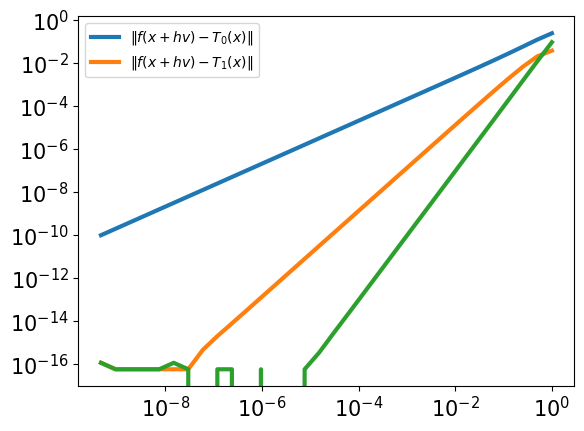

In [ ]:
plt.loglog(h, err0, linewidth = 3)
plt.loglog(h, err1, linewidth = 3)
plt.loglog(h, err2, linewidth = 3)
plt.legend(['$\|f(x+hv) - T_0(x)\|$', '$\|f(x+hv) - T_1(x)\|$'])
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)